In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC

# Color Features

In [2]:
img = cv2.imread('/Users/ryank/Documents/datasets/vehicles/GTI_MiddleClose/image0000.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

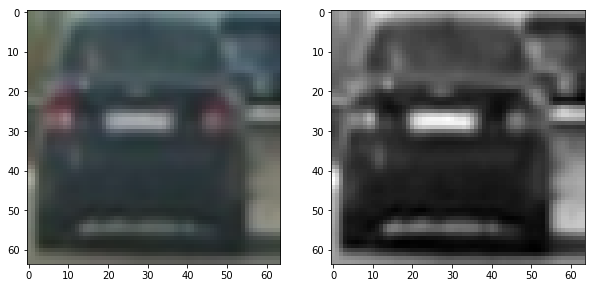

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(gray, cmap='gray')

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [5]:
color_features = color_hist(img)

In [6]:
len(color_features[-1])

96

<Container object of 96 artists>

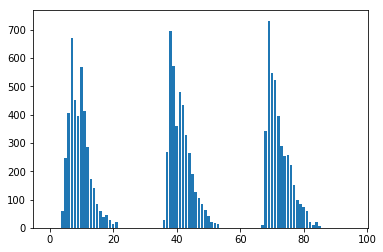

In [7]:
plt.bar(np.arange(len(color_features[-1])), color_features[-1])

In [8]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='BGR', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [9]:
spatial_features = bin_spatial(img)

In [10]:
len(spatial_features)

3072

<Container object of 3072 artists>

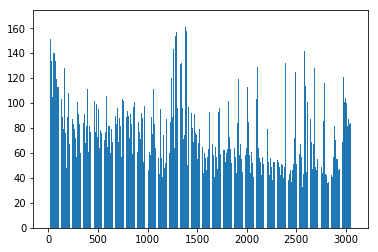

In [11]:
plt.bar(np.arange(len(spatial_features)), spatial_features)

# Gradient Features

In [12]:
img = cv2.imread('/Users/ryank/Documents/datasets/vehicles/GTI_MiddleClose/image0000.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

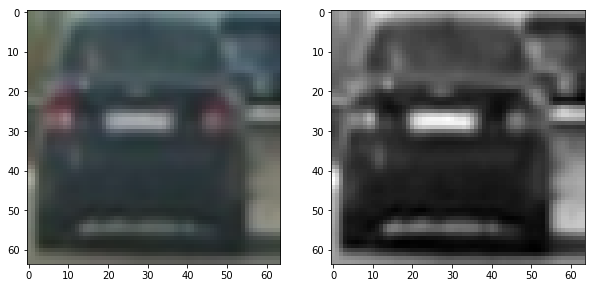

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(gray, cmap='gray')

In [14]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

hog_features, hog_image = hog(gray, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

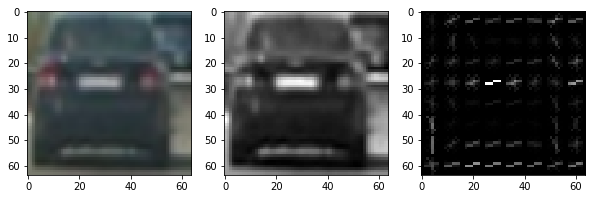

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img[:,:,::-1])
plt.subplot(132)
plt.imshow(gray, cmap='gray')
plt.subplot(133)
plt.imshow(hog_image, cmap='gray')

In [16]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [17]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

hog_features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block)

In [18]:
hog_features

array([0.02268886, 0.01514235, 0.00714213, ..., 0.00285263, 0.00025282,
       0.00026326])

<Container object of 1764 artists>

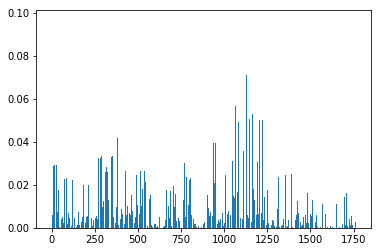

In [19]:
plt.bar(np.arange(len(hog_features)), hog_features)

# Vehicle / Non-vehicle Training Data

In [20]:
vehicle_glob = glob.glob('/Users/ryank/Documents/datasets/vehicles/**/*.png')
non_vehicle_glob = glob.glob('/Users/ryank/Documents/datasets/non-vehicles/**/*.png')

In [21]:
print(len(vehicle_glob))
print(len(non_vehicle_glob))

8792
8968


In [22]:
# read vehicle images
vehicle_imgs = []
for f in vehicle_glob:
    vehicle_imgs.append(cv2.imread(f))
vehicle_imgs = np.array(vehicle_imgs)

print(vehicle_imgs.shape)

(8792, 64, 64, 3)


In [23]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

# create vehicle gradient features
vehicle_gradient_features = []
for img in vehicle_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gradient_features, _ = get_hog_features(gray, orient, pix_per_cell, cell_per_block)
    vehicle_gradient_features.append(gradient_features)
vehicle_gradient_features = np.array(vehicle_gradient_features)

# create vehicle spatial features
vehicle_spatial_features = []
for img in vehicle_imgs:
    spatial_features = bin_spatial(img)
    vehicle_spatial_features.append(spatial_features)
vehicle_spatial_features = np.array(vehicle_spatial_features)
    
# create vehicle color features
vehicle_color_features = []
for img in vehicle_imgs:
    color_features = color_hist(img)
    vehicle_color_features.append(color_features[-1])
vehicle_color_features = np.array(vehicle_color_features)

In [24]:
vehicle_y = np.array([1] * len(vehicle_imgs))

In [25]:
# read non-vehicle images
non_vehicle_imgs = []
for f in non_vehicle_glob:
    non_vehicle_imgs.append(cv2.imread(f))
non_vehicle_imgs = np.array(non_vehicle_imgs)

print(non_vehicle_imgs.shape)

(8968, 64, 64, 3)


In [26]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

# create non-vehicle gradient features
non_vehicle_gradient_features = []
for img in non_vehicle_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gradient_features, _ = get_hog_features(gray, orient, pix_per_cell, cell_per_block)
    non_vehicle_gradient_features.append(gradient_features)
non_vehicle_gradient_features = np.array(non_vehicle_gradient_features)
    
# create non-vehicle spatial features
non_vehicle_spatial_features = []
for img in non_vehicle_imgs:
    spatial_features = bin_spatial(img)
    non_vehicle_spatial_features.append(spatial_features)
non_vehicle_spatial_features = np.array(non_vehicle_spatial_features)
    
# create non-vehicle color features
non_vehicle_color_features = []
for img in non_vehicle_imgs:
    color_features = color_hist(img)
    non_vehicle_color_features.append(color_features[-1])
non_vehicle_color_features = np.array(non_vehicle_color_features)

In [27]:
non_vehicle_y = np.array([0] * len(non_vehicle_imgs))

# Split

In [28]:
VGF_train, VGF_test, v_y_train, v_y_test = train_test_split(vehicle_gradient_features, vehicle_y, test_size=0.2, random_state=42)
VSF_train, VSF_test, v_y_train, v_y_test = train_test_split(vehicle_spatial_features, vehicle_y, test_size=0.2, random_state=42)
VCF_train, VCF_test, v_y_train, v_y_test = train_test_split(vehicle_color_features, vehicle_y, test_size=0.2, random_state=42)

NVGF_train, NVGF_test, nv_y_train, nv_y_test = train_test_split(non_vehicle_gradient_features, non_vehicle_y, test_size=0.2, random_state=42)
NVSF_train, NVSF_test, nv_y_train, nv_y_test = train_test_split(non_vehicle_spatial_features, non_vehicle_y, test_size=0.2, random_state=42)
NVCF_train, NVCF_test, nv_y_train, nv_y_test = train_test_split(non_vehicle_color_features, non_vehicle_y, test_size=0.2, random_state=42)

In [29]:
GF_train = np.concatenate([VGF_train, NVGF_train])
SF_train = np.concatenate([VSF_train, NVSF_train])
CF_train = np.concatenate([VCF_train, NVCF_train])

GF_test = np.concatenate([VGF_test, NVGF_test])
SF_test = np.concatenate([VSF_test, NVSF_test])
CF_test = np.concatenate([VCF_test, NVCF_test])

y_train = np.concatenate([v_y_train, nv_y_train])
y_test = np.concatenate([v_y_test, nv_y_test])

# Scale

In [30]:
gradient_scaler = StandardScaler()
spatial_scaler = StandardScaler()
color_scaler = StandardScaler()

GF_train_scaled = gradient_scaler.fit_transform(GF_train)
SF_train_scaled = spatial_scaler.fit_transform(SF_train)
CF_train_scaled = color_scaler.fit_transform(CF_train)

GF_test_scaled = gradient_scaler.transform(GF_test)
SF_test_scaled = spatial_scaler.transform(SF_test)
CF_test_scaled = color_scaler.transform(CF_test)

/Users/ryank/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ryank/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
X_train = np.concatenate([GF_train_scaled, SF_train_scaled, CF_train_scaled], axis=1)
X_test = np.concatenate([GF_test_scaled, SF_test_scaled, CF_test_scaled], axis=1)

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14207, 4932) (14207,)
(3553, 4932) (3553,)


In [ ]:
#here

# SVM Classifier

In [ ]:
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=4,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



In [33]:
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier(n_estimators=20)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(X_train, y_train)

report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.979 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_features': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.978 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_features': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.977 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_features': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}



In [36]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9795
